# **Hybrid Classification Model**



#Packages and Setting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/CapstoneProject/Final_folder/Skeleton/Raw_Data/

/content/drive/.shortcut-targets-by-id/1Xg_YHrJtqmQDmfdI0zK5_iYT8GrsjK6n/CapstoneProject/Data/Raw data


In [1]:
import os
current_dir = os.getcwd()

In [2]:
cd Raw_data

C:\Users\Joyqiao\Documents\CMU\CAPSTONE\SAS\SAS\CapstoneProject\Final_folder\Skeleton\Raw_data


In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk 
nltk.download('stopwords')  
import datetime
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict,cross_validate
import statsmodels as sm
from sklearn.inspection import permutation_importance
from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,label_binarize
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
import lightgbm as lgb

plt.rcParams.update({'figure.figsize': (12.0, 12.0)})


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joyqiao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Inspection text TFIDF


## Clean Text

In [6]:
#read in 2019 inspection report
inspection_report = pd.read_csv('cms_all_2567_2019.csv',encoding='latin1')

In [7]:
#define a feunction that remove initial comment before** or > characters if exists 
def remove_pre_sentence(text):
    text = text.apply(lambda x: x.split('** ')[1] if x.startswith("**") else x)
    text = text.apply(lambda x: x[1:] if x.startswith(">") else x)  
    return text

In [8]:
#apply the function to inspection text
inspection_report ['inspection_text'] = remove_pre_sentence(inspection_report ['inspection_text'])
inspection_report ['inspection_text'].head()

0    <BR/>Based on clinical record reviews, review ...
1    <BR/>Based on observation, interviews and revi...
2    <BR/>Based on review of the clinical records, ...
3    <BR/>Based on review of the clinical record, f...
4    <BR/>Based on observations, review of facility...
Name: inspection_text, dtype: object

In [9]:
#define a function that extract the text of html tag
from bs4 import BeautifulSoup
def remove_html_tags(text):
    text = text.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return text

In [10]:
#apply the function to inspection text
inspection_report ['inspection_text'] = remove_html_tags(inspection_report ['inspection_text'])
inspection_report ['inspection_text'].head()

0    Based on clinical record reviews, review of fa...
1    Based on observation, interviews and review of...
2    Based on review of the clinical records, facil...
3    Based on review of the clinical record, facili...
4    Based on observations, review of facility docu...
Name: inspection_text, dtype: object

In [11]:
#concat every row of inspection text into one by facility id
#keep facility id and text columns only
inspection_report ['concate_text'] = inspection_report[['inspection_text','facility_id']].groupby(['facility_id'])['inspection_text'].transform(lambda x: '.'.join(x))
inspection_report  = inspection_report [['facility_id','concate_text']]

inspection_report  = inspection_report.drop_duplicates() 
insepction_id = inspection_report['facility_id']

In [12]:
#define a function to replace special characters to whitespace
def process_data(X):
    processed_texts = []
    for processed_text in X:  
      # Remove all the special characters
      #processed_text = re.sub('\W+', '', X[text])


      # remove all single characters
      processed_text = re.sub(r'\s+[a-zA-Z]\s+', ' ',processed_text)

      # Remove single characters from the start
      processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text) 

      # Substituting multiple spaces with single space
      processed_text= re.sub(r'\s+', ' ', processed_text, flags=re.I)

      # Removing prefixed 'b'
      processed_text = re.sub(r'^b\s+', '', processed_text)

      # Converting to Lowercase
      processed_text = processed_text.lower()

      processed_texts.append(processed_text)

    return processed_texts


In [13]:
#apply the function to inspection text
processed_texts = process_data(inspection_report['concate_text'])


## Apply TFIDF to inspection text to vectorize unstructured data

In [14]:
# only consider the top 1500 words ordered by term frequency across the corpus
tfidfconverter = TfidfVectorizer(max_features=1500,ngram_range = (1,2),max_df = 0.8,stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(processed_texts).toarray()


In [15]:
#display shape of vectorized text array
X.shape

(13678, 1500)

In [16]:
#reduce dimensionality of array with truncatedSVD
svd = TruncatedSVD(n_components = 300,n_iter = 7,random_state = 42)
text_X = svd.fit_transform(X)


In [17]:
#display explained variance and shape of vectorized text array
display(svd.explained_variance_ratio_.sum())
print(text_X.shape)


0.7752121867714956

(13678, 300)


In [18]:
#transform text array to dataframe
text_X  = pd.DataFrame(text_X)
text_X['facility_id'] = insepction_id.reset_index().iloc[:,-1]

In [5]:
text_X

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,facility_id
0,0.414703,-0.100232,0.007271,0.076383,-0.146120,-0.102721,0.167444,0.076539,0.247042,-0.123708,...,0.002553,0.018487,0.015555,-0.003051,0.044155,-0.006887,-0.001179,0.001622,-0.001926,075011
1,0.361707,-0.092712,0.052220,0.023638,-0.111557,-0.061093,0.151330,0.078270,0.046043,0.002520,...,-0.015194,0.059713,-0.030495,-0.024371,-0.015190,-0.041363,-0.014489,-0.074068,0.008598,075013
2,0.375500,-0.091886,0.058431,0.062510,-0.129616,-0.077788,0.132900,0.127784,0.042323,0.006578,...,-0.019045,0.002012,0.009854,0.019561,0.003141,-0.007631,0.016122,-0.009719,-0.008799,075017
3,0.363383,-0.065194,0.037792,0.065079,-0.123942,-0.049024,0.169274,0.102527,0.101188,-0.049978,...,-0.004905,0.028720,0.005139,-0.006711,-0.001709,0.012942,0.025357,-0.007544,-0.000087,075028
4,0.334058,-0.087407,0.022888,0.026060,-0.114895,-0.035752,0.180382,0.041274,0.104198,-0.030555,...,0.011734,0.005120,0.024990,0.024138,-0.017723,-0.012480,-0.007614,0.006318,0.016455,075031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13673,0.214647,-0.044775,0.073796,0.016053,0.001882,-0.056774,-0.025882,0.096186,-0.114962,0.120908,...,0.032081,-0.017366,-0.026831,-0.019521,0.003466,0.051758,-0.051184,-0.024480,0.004185,555915
13674,0.609040,-0.229030,0.222754,-0.148503,-0.119856,0.110003,-0.100304,-0.117740,-0.081546,-0.038069,...,0.002623,0.032864,-0.020759,0.000165,0.006139,-0.007248,-0.005377,0.005224,0.018526,555917
13675,0.386391,-0.140662,0.129260,-0.138723,-0.042513,0.094244,-0.105076,-0.183965,-0.068783,-0.049908,...,-0.006942,0.019114,-0.009632,0.014889,-0.021495,-0.018552,0.018086,0.017121,-0.004159,555918
13676,0.321579,-0.093613,0.061083,-0.086648,-0.057995,0.068445,0.009687,-0.076498,-0.046772,-0.004699,...,0.008709,-0.011621,0.023044,0.018026,-0.023051,-0.009124,0.002904,0.020037,-0.017503,555919


In [20]:
text_X.to_csv('unstructured_data.csv')

In [4]:
text_X = pd.read_csv('unstructured_data.csv',index_col = 0)

# Structured data preprecessing

## Load preprocessed data

In [6]:
os.chdir(os.path.join(current_dir,'Final_Output'))

In [ ]:
cd /content/drive/MyDrive/CapstoneProject/Final_folder/Skeleton/Final_Output/

/content/drive/.shortcut-targets-by-id/1Xg_YHrJtqmQDmfdI0zK5_iYT8GrsjK6n/CapstoneProject/Data/Processed Output


In [8]:
#read in structured data 
structured_data = pd.read_csv('final_dataframe.csv')
len(set(structured_data.columns))

C:\Users\Joyqiao\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,84,85,86,87,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


159

In [9]:
#display unique nursing home contained in the modeling
structured_data['Federal Provider Number'].astype('str').nunique()

12578

In [10]:
#display structured data
pd.set_option('display.max_columns',200)
structured_data.head()

,Federal Provider Number,Number of All Beds,Total Number of Occupied Beds,Residents Weekly Admissions COVID-19,Residents Weekly Confirmed COVID-19,Residents Weekly Suspected COVID-19,Residents Weekly All Deaths,Residents Weekly COVID-19 Deaths,Resident Access to Testing in Facility,Laboratory Type Is State Health Dept,Laboratory Type Is Private Lab,Laboratory Type Is Other,Able to Test or Obtain Resources to Test All Current Residents Within Next 7 Days,Reason for Not Testing Residents - Lack of PPE for Personnel,Reason for Not Testing Residents - Lack of Supplies,Reason for Not Testing Residents - Lack of Access to Laboratory,Reason for Not Testing Residents - Lack of Access to Trained Personnel,Reason for Not Testing Residents - Uncertainty About Reimbursement,Reason for Not Testing Residents - Other,Has Facility Performed Resident Tests Since Last Report,Tested Asymptomatic Residents in a Unit or Section After a New Case,Tested Asymptomatic Residents Facility-Wide After a New Case,Tested Asymptomatic Residents Without Known Exposure as Surveillance,Tested Another Subgroup of Residents,Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days,Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel,Reason for Not Testing Staff and/or Personnel - Lack of Supplies,Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory,Reason for Not Testing Staff and/or Personnel - Lack of Access to Trained Personnel,Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement,Reason for Not Testing Staff and/or Personnel - Other,Has Facility Performed Staff and/or Personnel Tests Since Last Report,Tested Asymptomatic Staff and/or Personnel in a Unit or Section After a New Case,Tested Asymptomatic Staff and/or Personnel Facility-Wide After a New Case,Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance,Tested Another Subgroup of Staff and/or Personnel,Staff Weekly Confirmed COVID-19,Staff Weekly Suspected COVID-19,Staff Weekly COVID-19 Deaths,Shortage of Nursing Staff,Shortage of Clinical Staff,Shortage of Aides,Shortage of Other Staff,Any Current Supply of N95 Masks,One-Week Supply of N95 Masks,Any Current Supply of Surgical Masks,One-Week Supply of Surgical Masks,Any Current Supply of Eye Protection,One-Week Supply of Eye Protection,Any Current Supply of Gowns,One-Week Supply of Gowns,Any Current Supply of Gloves,One-Week Supply of Gloves,Any Current Supply of Hand Sanitizer,One-Week Supply of Hand Sanitizer,Three or More Confirmed COVID-19 Cases This Week,suspected_but_no_test_resident,suspected_but_no_test_staff,Ventilator Dependent Unit,Number of Ventilators in Facility,Number of Ventilators in Use for COVID-19,Any Current Supply of Ventilator Supplies,One-Week Supply of Ventilator Supplies,In-House Point-of-Care Test Machine,COVID-19 Point-of-Care Tests Performed on Residents Since Last Report,COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report,Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine,Week Initial Case,May_24_Residents Total Admissions COVID-19,May_24_Residents Total Confirmed COVID-19,May_24_Residents Total Suspected COVID-19,May_24_Residents Total All Deaths,May_24_Residents Total COVID-19 Deaths,May_24_Total Number of Occupied Beds,May_24_Staff Total Confirmed COVID-19,May_24_Staff Total Suspected COVID-19,May_24_Staff Total COVID-19 Deaths,cut_time,alzunit,anyunit,multifac,restrain,acuindex2,anymdex,rn2nrs,nhlong,nhlat,occpct,avgage,pctfem,pctblack_2011p,pcthisp_2011p,pctwhite_2011p,pcthyper,NHCADL_2011p,adj_rehosprate,adj_successfuldc,adj_medianlos,Provider City,Provider State,Provider Zip Code,Provider SSA County,Ownership Type,Number of Certified Beds,Average Number of Residents Per Day,Provider Type,Provider Resides in Hospital,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years 


## Imputation

In [11]:
#count non-value columns
pd.set_option('display.max_row',200)
structured_data.isnull().sum()

Federal Provider Number                                                                      0
Number of All Beds                                                                           0
Total Number of Occupied Beds                                                                0
Residents Weekly Admissions COVID-19                                                         0
Residents Weekly Confirmed COVID-19                                                          0
Residents Weekly Suspected COVID-19                                                          0
Residents Weekly All Deaths                                                                  0
Residents Weekly COVID-19 Deaths                                                             0
Resident Access to Testing in Facility                                                       0
Laboratory Type Is State Health Dept                                                         0
Laboratory Type Is Private Lab                    

In [18]:
#collect statistics of all columns contain null to assist imputation method selection
missing_chart = structured_data.loc[:,structured_data.isnull().sum() != 0]
missing_chart.describe()

,Adiministration_severity,Environmental_severity,AbuseNeglect_severity,NursingDietary_severity,Nutrition_severity,Pharmacy_severity,QualityLife_severity,CarePlanning_severity,Rights_severity
count,237785.000000,237785.000000,237785.000000,237785.000000,237785.000000,237785.000000,237785.000000,237785.000000,237785.000000
mean,0.020184,0.109168,0.072047,0.129399,0.029821,0.113967,0.253157,0.148133,0.124124
std,0.068870,0.169622,0.161436,0.204221,0.083744,0.168827,0.235634,0.190322,0.169966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027000,0.000000,0.000000
50%,0.000000,0.042000,0.000000,0.000000,0.000000,0.053000,0.214000,0.091000,0.074000
75%,0.000000,0.154000,0.071000,0.200000,0.000000,0.167000,0.385000,0.217000,0.188000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#use mean value to impute non value
imputer = SimpleImputer(strategy = 'mean')
structured_data[missing_chart.columns] = imputer.fit_transform(missing_chart)

In [25]:
#delete unnecessary columns
drop_list = ['paymcaid','paymcare','adm_bed','NHCpain_2011p','NHCpu_2011p','pctNHdaysSNF','hospptyr','obs_rehosprate',
   'obs_successfuldc', 'obs_medianlos', 'PctPvtDays',  'Provider Name',  'Provider Address', 'Date First Approved to Provide Medicare and Medicaid services','Provider Zip Code','Provider SSA County','Provider States','Provider State','Provider City','nhlong','occpct'
            ,'nhlat']
for col in drop_list:
    if col in structured_data.columns:
        del structured_data[col]

In [26]:
#clean data format
structured_data['rn2nrs'] = structured_data['rn2nrs'].replace('.','0')
#structured_data['occpct'] = structured_data['occpct'].replace('.','0')
structured_data['adj_rehosprate'] = structured_data['adj_rehosprate'].replace('.','0')
structured_data['adj_successfuldc'] = structured_data['adj_successfuldc'].replace('.','0')
structured_data['adj_medianlos'] = structured_data['adj_medianlos'].replace('.','0')
structured_data['NHCADL_2011p'] = structured_data['NHCADL_2011p'].replace('.','0')
#structured_data['nhlong'] = structured_data['nhlong'].replace('.','-999')
#structured_data['nhlat'] = structured_data['nhlat'].replace('.','-999')
structured_data['rn2nrs'] = structured_data['rn2nrs'].astype('float')
#structured_data['occpct'] = structured_data['occpct'].astype('float')
structured_data['adj_rehosprate'] = structured_data['adj_rehosprate'].astype('float')
structured_data['adj_successfuldc'] = structured_data['adj_successfuldc'].astype('float')
structured_data['adj_medianlos'] = structured_data['adj_medianlos'].astype('float')
structured_data['NHCADL_2011p'] = structured_data['NHCADL_2011p'].astype('float')
#structured_data['nhlong'] = structured_data['nhlong'].astype('float')
#structured_data['nhlat'] = structured_data['nhlat'].astype('float')
# structured_data['Provider Zip Code'] = structured_data['Provider Zip Code'].astypes('category')                          
# structured_data['Provider SSA County'] = structured_data['Provider SSA County'].astypes('category')  
structured_data['suspected_but_no_test_staff'] = structured_data['suspected_but_no_test_staff'].astype('category')
structured_data['suspected_but_no_test_resident'] = structured_data['suspected_but_no_test_resident'].astype('category')


In [27]:
structured_data['cut_time']

0         2020-07-05
1         2020-07-12
2         2020-07-19
3         2020-07-26
4         2020-08-02
             ...    
238825    2020-10-11
238826    2020-10-18
238827    2020-10-25
238828    2020-11-01
238829    2020-11-08
Name: cut_time, Length: 238830, dtype: object

In [28]:
#get the mean value of last 4 weeks of community infecion and death case number in ny times
structured_data['case_ny_current_month'] = structured_data[[i for i in structured_data.columns if re.search(r'(case)\d{1}',i)]].mean(axis = 1)

structured_data['death_ny_current_month'] = structured_data[[i for i in structured_data.columns if re.search(r'(death)\d{1}',i)]].mean(axis = 1)
structured_data = structured_data.drop(['case1','case2','case3','case4','death1','death2','death3','death4'],axis = 1)

## Label


In [32]:
#read in label

label = pd.read_csv('final_dataframe_label.csv')

In [33]:
label

,Federal Provider Number,Residents Weekly Confirmed COVID-19,Residents Weekly COVID-19 Deaths,infection_rate,cut_time
0,015009,0.0,0.0,0.000000,2020-07-05
1,015010,0.0,0.0,0.000000,2020-07-05
2,015012,0.0,0.0,0.000000,2020-07-05
3,015014,3.0,0.0,0.067568,2020-07-05
4,015015,0.0,0.0,0.000000,2020-07-05
...,...,...,...,...,...
322330,676485,0.0,0.0,0.000000,2020-11-08
322331,676487,0.0,0.0,0.000000,2020-11-08
322332,676488,0.0,0.0,0.000000,2020-11-08
322333,686123,0.0,0.0,0.000000,2020-11-08


In [34]:
label = label.sort_values(by = ['Federal Provider Number','cut_time'])

In [35]:
#calculate mortality rate as new label
label['mortality_rate'] = label['Residents Weekly COVID-19 Deaths']/label['Residents Weekly Confirmed COVID-19']

In [36]:
label

,Federal Provider Number,Residents Weekly Confirmed COVID-19,Residents Weekly COVID-19 Deaths,infection_rate,cut_time,mortality_rate
0,015009,0.0,0.0,0.0,2020-07-05,NaN
16965,015009,0.0,0.0,0.0,2020-07-12,NaN
33930,015009,0.0,0.0,0.0,2020-07-19,NaN
50895,015009,0.0,0.0,0.0,2020-07-26,NaN
67860,015009,0.0,0.0,0.0,2020-08-02,NaN
...,...,...,...,...,...,...
254474,686124,0.0,0.0,0.0,2020-10-11,NaN
271439,686124,0.0,0.0,0.0,2020-10-18,NaN
288404,686124,0.0,0.0,0.0,2020-10-25,NaN
305369,686124,0.0,0.0,0.0,2020-11-01,NaN


In [37]:
#label imputation
label = label.fillna(0) #only when infection and mortality number are both 0, the division will return nan
#store max mortality and infection rate to replace infinity value(resulted due to 0 denominator)
max_mortality = sorted(set(label['mortality_rate']))[-2]
max_infection = sorted(set(label['infection_rate']))[-2]

In [40]:
#impute mortality and infection rate
label = label.fillna(0) #only when infection and mortality number are both 0, the division will return nan
max(label['mortality_rate'])
label['mortality_rate'] = label['mortality_rate'].replace(np.inf,max_mortality)
label['infection_rate'] = label['infection_rate'].replace(np.inf,max_infection)

In [51]:
help(sns.FacetGrid)

Help on class FacetGrid in module seaborn.axisgrid:

class FacetGrid(Grid)
 |  FacetGrid(data, row=None, col=None, hue=None, col_wrap=None, sharex=True, sharey=True, height=3, aspect=1, palette=None, row_order=None, col_order=None, hue_order=None, hue_kws=None, dropna=True, legend_out=True, despine=True, margin_titles=False, xlim=None, ylim=None, subplot_kws=None, gridspec_kws=None, size=None)
 |  
 |  Multi-plot grid for plotting conditional relationships.
 |  
 |  Method resolution order:
 |      FacetGrid
 |      Grid
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, row=None, col=None, hue=None, col_wrap=None, sharex=True, sharey=True, height=3, aspect=1, palette=None, row_order=None, col_order=None, hue_order=None, hue_kws=None, dropna=True, legend_out=True, despine=True, margin_titles=False, xlim=None, ylim=None, subplot_kws=None, gridspec_kws=None, size=None)
 |      Initialize the matplotlib figure and FacetGrid object.
 |      
 |      This c

In [69]:
help(sns.distplot)

Help on function distplot in module seaborn.distributions:

distplot(a, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
    Flexibly plot a univariate distribution of observations.
    
    This function combines the matplotlib ``hist`` function (with automatic
    calculation of a good default bin size) with the seaborn :func:`kdeplot`
    and :func:`rugplot` functions. It can also fit ``scipy.stats``
    distributions and plot the estimated PDF over the data.
    
    Parameters
    ----------
    
    a : Series, 1d-array, or list.
        Observed data. If this is a Series object with a ``name`` attribute,
        the name will be used to label the data axis.
    bins : argument for matplotlib hist(), or None, optional
        Specification of hist bins. If unspecified, as reference rule is used
        that tries to find a useful default.
  

In [73]:
from scipy.stats import norm
norm.cdf(label['infection_rate'])

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

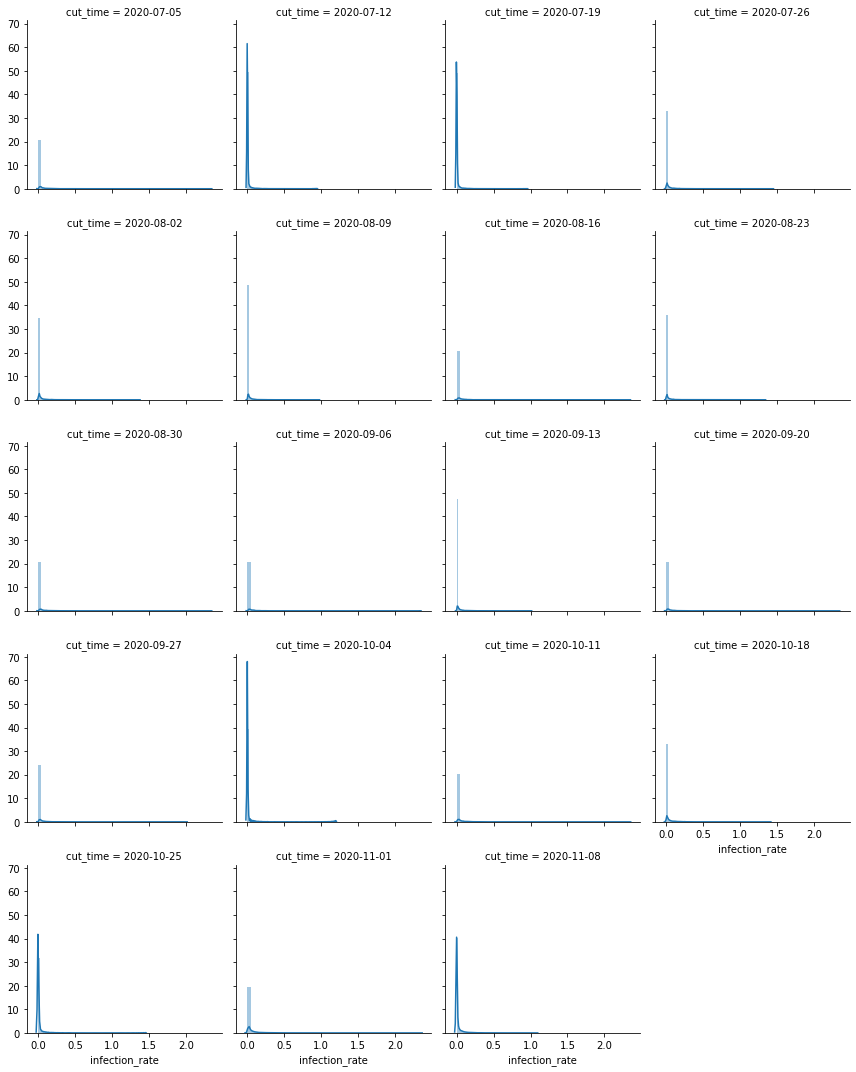

In [67]:
#distribition of infection rate by cut time

g = sns.FacetGrid( data = label, col = 'cut_time',col_wrap = 4)
g = g.map(sns.distplot,'infection_rate',hist = True, kde = True)

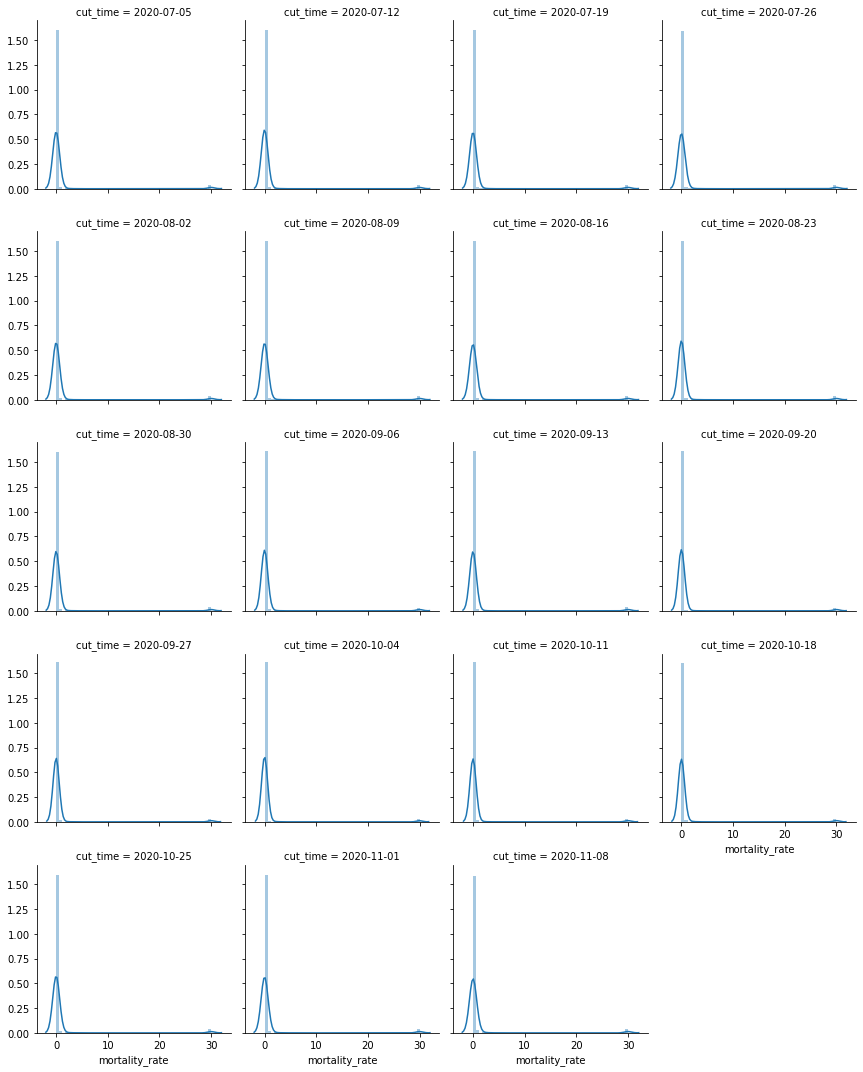

In [68]:
#distribition of mortality rate by cut time
g = sns.FacetGrid( data = label, col = 'cut_time',col_wrap = 4)
g = g.map(sns.distplot,'mortality_rate',hist = True, kde = True)

In [ ]:
# label['Residents Weekly Confirmed COVID-19'] = pd.cut(x=label['Residents Weekly Confirmed COVID-19'], bins=[0, 0.99,2,10,np.inf],include_lowest = True)

In [ ]:
# label['mortality_rate'] =pd.cut(x=label['mortality_rate'], bins=[0, 0.01,0.1,1,np.inf],include_lowest = True)

In [ ]:
# get the cut of mortality rate into categories
mortality_rate_label = pd.DataFrame(pd.cut(x=label['mortality_rate'], bins=[-0.01, 0,0.0184,np.inf],include_lowest = False))
mortality_rate_label.value_counts()

from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()
# transform 
mortality_rate_label = encoder.fit_transform(mortality_rate_label)
label = pd.concat([label,pd.DataFrame(mortality_rate_label,columns = ['mortality_rate_label'])],axis = 1)

In [ ]:
# cut the infection rate into categories
infection_rate_label = pd.DataFrame(pd.cut(x=label['infection_rate'], bins=[-0.01, 0,0.049,np.inf],include_lowest = False))

from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()
# transform 
infection_rate_label = encoder.fit_transform(infection_rate_label)
label = pd.concat([label,pd.DataFrame(infection_rate_label,columns = ['infection_rate_label'])],axis = 1)

In [ ]:
infection_rate_label.value_counts()

infection_rate
(-0.01, 0.0]      284059
(0.0, 0.049]       24453
(0.049, inf]       13823
dtype: int64

In [ ]:
label['infection_rate_label'].value_counts()

0.0    284059
1.0     24453
2.0     13823
Name: infection_rate_label, dtype: int64

In [ ]:
#merge X and y into combined verison of structure data
xy = structured_data.merge(label,on = ['Federal Provider Number','cut_time'],how = 'left')

In [ ]:
label.describe()

,Residents Weekly Confirmed COVID-19,Residents Weekly COVID-19 Deaths,infection_rate,mortality_rate,mortality_rate_label,infection_rate_label
count,322335.000000,322335.000000,322335.000000,322335.000000,322335.000000,322335.000000
mean,0.598362,0.094482,0.008234,0.447378,0.150421,0.161630
std,2.457419,0.473859,0.043234,2.850850,0.527392,0.470398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,86.000000,22.000000,2.333333,30.000000,2.000000,2.000000


In [ ]:
#split the training and test data
xy = xy.fillna(0)
xy['train_test'] = 0
xy.loc[xy['cut_time'] ==max(xy['cut_time']) ,'train_test'] =1 
data_train_test = xy['train_test']




In [ ]:
#split X and y
data_y = xy.iloc[:,-7:]
data_y = pd.concat([data_y,xy[['cut_time']]],axis = 1)
data_X = xy.iloc[:,:-7]
data_X_id = data_X['Federal Provider Number']
data_X = data_X.drop('Federal Provider Number',axis = 1)
data_X['cut_time_month'] = pd.to_datetime(data_X['cut_time']).dt.month.astype('object')


In [ ]:
#separate columns types for later encoding
types = np.array([dt for dt in data_X.dtypes])
all_columns = data_X.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]

In [ ]:
#define function to get the customized cv for later model cross validation
def customize_cv(data,nfold = 3):
  '''for parameter tuning'''
  sort_cut_time = sorted(data_y['cut_time'].unique())
  cv = []
  data_ = data.reset_index()
  for current_time in sort_cut_time[-(1+nfold):-1]:
    idx_train = data_[data_['cut_time'] < current_time].index
    idx_validate = data_[data_['cut_time'] == current_time].index
    cv.append((idx_train,idx_validate))
  return cv


## Multiconealirity One hot Encoding

In [ ]:
#first deal with numeric columns
data_X_numeric = data_X[num_cols]

In [ ]:
len(set(data_X_numeric.columns))

135

In [ ]:
data_X_numeric

,Number of All Beds,Total Number of Occupied Beds,Residents Weekly Admissions COVID-19,Residents Weekly Confirmed COVID-19_x,Residents Weekly Suspected COVID-19,Residents Weekly All Deaths,Residents Weekly COVID-19 Deaths_x,Resident Access to Testing in Facility,Laboratory Type Is State Health Dept,Laboratory Type Is Private Lab,Laboratory Type Is Other,Able to Test or Obtain Resources to Test All Current Residents Within Next 7 Days,Reason for Not Testing Residents - Lack of PPE for Personnel,Reason for Not Testing Residents - Lack of Supplies,Reason for Not Testing Residents - Lack of Access to Laboratory,Reason for Not Testing Residents - Lack of Access to Trained Personnel,Reason for Not Testing Residents - Uncertainty About Reimbursement,Reason for Not Testing Residents - Other,Has Facility Performed Resident Tests Since Last Report,Tested Asymptomatic Residents in a Unit or Section After a New Case,Tested Asymptomatic Residents Facility-Wide After a New Case,Tested Asymptomatic Residents Without Known Exposure as Surveillance,Tested Another Subgroup of Residents,Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days,Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel,Reason for Not Testing Staff and/or Personnel - Lack of Supplies,Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory,Reason for Not Testing Staff and/or Personnel - Lack of Access to Trained Personnel,Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement,Reason for Not Testing Staff and/or Personnel - Other,Has Facility Performed Staff and/or Personnel Tests Since Last Report,Tested Asymptomatic Staff and/or Personnel in a Unit or Section After a New Case,Tested Asymptomatic Staff and/or Personnel Facility-Wide After a New Case,Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance,Tested Another Subgroup of Staff and/or Personnel,Staff Weekly Confirmed COVID-19,Staff Weekly Suspected COVID-19,Staff Weekly COVID-19 Deaths,Shortage of Nursing Staff,Shortage of Clinical Staff,Shortage of Aides,Shortage of Other Staff,Any Current Supply of N95 Masks,One-Week Supply of N95 Masks,Any Current Supply of Surgical Masks,One-Week Supply of Surgical Masks,Any Current Supply of Eye Protection,One-Week Supply of Eye Protection,Any Current Supply of Gowns,One-Week Supply of Gowns,Any Current Supply of Gloves,One-Week Supply of Gloves,Any Current Supply of Hand Sanitizer,One-Week Supply of Hand Sanitizer,Three or More Confirmed COVID-19 Cases This Week,suspected_but_no_test_resident,suspected_but_no_test_staff,Ventilator Dependent Unit,Number of Ventilators in Facility,Number of Ventilators in Use for COVID-19,Any Current Supply of Ventilator Supplies,One-Week Supply of Ventilator Supplies,In-House Point-of-Care Test Machine,COVID-19 Point-of-Care Tests Performed on Residents Since Last Report,COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report,Enough Supplies to Test All Staff and/or Personnel Using Point-of-Care Test Machine,May_24_Residents Total Admissions COVID-19,May_24_Residents Total Confirmed COVID-19,May_24_Residents Total Suspected COVID-19,May_24_Residents Total All Deaths,May_24_Residents Total COVID-19 Deaths,May_24_Total Number of Occupied Beds,May_24_Staff Total Confirmed COVID-19,May_24_Staff Total Suspected COVID-19,May_24_Staff Total COVID-19 Deaths,restrain,acuindex2,rn2nrs,avgage,pctfem,pctblack_2011p,pcthisp_2011p,pctwhite_2011p,pcthyper,NHCADL_2011p,adj_rehosprate,adj_successfuldc,adj_medianlos,Number of Certified Beds,Average Number of Residents Per Day,Provider Resides in Hospital,Continuing Care Retirement Community,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,Overall Rating,QM Rating,Staffing Rating,RN Staffing Rating,Reported Licensed Staffing Hours per Resident per Day,Reported Physical Therapist Staffing Hours per Residen

In [ ]:
#consider colinearity and delete some of the high correlated columns
data_X_numeric = data_X_numeric.astype('float')
delete = [i for i in data_X_numeric.columns if re.search('(^Any)|(YN$)|(^Adjusted)',i)]
data_X_numeric = data_X_numeric.drop(delete,axis = 1)
data_X_numeric =data_X_numeric.drop('Number of All Beds',axis = 1)
data_X_numeric = data_X_numeric.drop(['Number of Certified Beds','Total Number of Penalties','Ventilator Dependent Unit',
                                      'Able to Test or Obtain Resources to Test All Staff and/or Personnel Within Next 7 Days',
                                     'Has Facility Performed Staff and/or Personnel Tests Since Last Report',
                                       'Tested Asymptomatic Staff and/or Personnel Without Known Exposure as Surveillance',
                                      'QM Rating','Staffing Rating','RN Staffing Rating'],
                                     axis = 1)




In [ ]:
#code for calculate the colinarity
# # VIF dataframe 
# vif_data = pd.DataFrame() 
# vif_data["feature"] = data_X_numeric.columns
  
# # calculating VIF for each feature 
# vif_data["VIF"] = [variance_inflation_factor(data_X_numeric.values, i) 
#                           for i in range(len(data_X_numeric.columns))] 
  
# print(vif_data)

In [ ]:
#another version of code to get rid off the columns with 0.9 or higher correlation
# corr = data_X_numeric.corr()
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.9:
#             if columns[j]:
#                 columns[j] = False
#selected_columns = data_X_numeric.columns[columns]


In [ ]:
#selected_columns = vif_data['feature'].values
#data_X_numeric = data_X_numeric[selected_columns]
data_X_numeric.shape

(238830, 105)

In [ ]:
#second encode the categorical columns
cat_cols

array(['Week Initial Case', 'cut_time', 'alzunit', 'anyunit', 'multifac',
       'anymdex', 'Ownership Type', 'Provider Type',
       'Special Focus Status', 'With a Resident and Family Council',
       'cut_time_month'], dtype=object)

In [ ]:
cat_cols = [i for i in cat_cols if i not in ('Week Initial Case','cut_time')]
data_X_categorical = data_X[cat_cols]
data_X_categorical.columns

Index(['alzunit', 'anyunit', 'multifac', 'anymdex', 'Ownership Type',
       'Provider Type', 'Special Focus Status',
       'With a Resident and Family Council', 'cut_time_month'],
      dtype='object')

In [ ]:
[data_X_categorical[column].unique() for column in data_X_categorical.columns]

[array(['No', 'Yes'], dtype=object),
 array(['Yes', 'No'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Yes', 'No'], dtype=object),
 array(['For profit - Corporation', 'Government - County',
        'For profit - Individual',
        'For profit - Limited Liability company', 'Non profit - Other',
        'Non profit - Corporation', 'For profit - Partnership',
        'Government - City', 'Non profit - Church related',
        'Government - Federal', 'Government - State',
        'Government - Hospital district', 'Government - City/county'],
       dtype=object),
 array(['Medicare and Medicaid', 'Medicare', 'Medicaid'], dtype=object),
 array(['not SFF', 'SFF Candidate', 'SFF'], dtype=object),
 array(['Both', 'Resident', 'None', 'Family'], dtype=object),
 array([7, 8, 9, 10, 11], dtype=object)]

In [ ]:
#get one hot encoding of categorical columns
data_X_categorical = pd.get_dummies(data_X_categorical,drop_first=True,prefix = data_X_categorical.columns)

In [ ]:
pd.set_option('display.max_column',200)
data_X_categorical

,alzunit_Yes,anyunit_Yes,multifac_Yes,anymdex_Yes,Ownership Type_For profit - Individual,Ownership Type_For profit - Limited Liability company,Ownership Type_For profit - Partnership,Ownership Type_Government - City,Ownership Type_Government - City/county,Ownership Type_Government - County,Ownership Type_Government - Federal,Ownership Type_Government - Hospital district,Ownership Type_Government - State,Ownership Type_Non profit - Church related,Ownership Type_Non profit - Corporation,Ownership Type_Non profit - Other,Provider Type_Medicare,Provider Type_Medicare and Medicaid,Special Focus Status_SFF Candidate,Special Focus Status_not SFF,With a Resident and Family Council_Family,With a Resident and Family Council_None,With a Resident and Family Council_Resident,cut_time_month_8,cut_time_month_9,cut_time_month_10,cut_time_month_11
0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
238826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
238827,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
238828,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1


In [ ]:
for i in data_X_categorical.columns:
  print(i)


alzunit_Yes
anyunit_Yes
multifac_Yes
anymdex_Yes
Ownership Type_For profit - Individual
Ownership Type_For profit - Limited Liability company
Ownership Type_For profit - Partnership
Ownership Type_Government - City
Ownership Type_Government - City/county
Ownership Type_Government - County
Ownership Type_Government - Federal
Ownership Type_Government - Hospital district
Ownership Type_Government - State
Ownership Type_Non profit - Church related
Ownership Type_Non profit - Corporation
Ownership Type_Non profit - Other
Provider Type_Medicare
Provider Type_Medicare and Medicaid
Special Focus Status_SFF Candidate
Special Focus Status_not SFF
With a Resident and Family Council_Family
With a Resident and Family Council_None
With a Resident and Family Council_Resident
cut_time_month_8
cut_time_month_9
cut_time_month_10
cut_time_month_11


In [ ]:
#concat categorical and numeric columns
data_X = pd.concat([data_X_categorical,data_X_numeric],axis=1)

## train test split

In [ ]:

#def split_tt(target_label,filter_label):
def split_tt(target_label):

    '''
    target_label str
    '''
    test_y = data_y[(data_y['train_test'] == 1)]
    train_y =  data_y[data_y['train_test'] == 0]
    test_X = data_X[data_X.index.isin(test_y.index)]
    train_X = data_X[data_X.index.isin(train_y.index)]
    # test_y = test_y.reset_index(drop = True)
    # train_y = train_y.reset_index(drop = True)
    # test_X = test_X.reset_index(drop = True)
    # train_X = train_X.reset_index(drop = True)
    #test_X = test_X[test_X[filter_label] != 0]
    #train_X = train_X[train_X[filter_label] != 0]
    #test_y = data_y[data_y.index.isin(test_X.index)]
    #train_y = data_y[data_y.index.isin(train_X.index)]
    customized_cv = customize_cv(train_y,nfold = 3)

    
    data_X_id_train = data_X_id[data_X_id.index.isin(train_X.index)]
    data_X_id_test = data_X_id[data_X_id.index.isin(test_X.index)]
    
    
    train_X_standard = train_X.copy()
    test_X_standard = test_X.copy()
    
    #scalar = StandardScaler()
    #scalar.fit(train_X[data_X_numeric.columns])
    #train_X_standard[data_X_numeric.columns] = scalar.transform(train_X[data_X_numeric.columns])
    #test_X_standard[data_X_numeric.columns] = scalar.transform(test_X[data_X_numeric.columns])

    selected_label = target_label
    train_y_new = train_y[selected_label]
    test_y_new = test_y[selected_label]
    
    
    
    return train_X_standard,test_X_standard,train_y_new,test_y_new,data_X_id_train,data_X_id_test,customized_cv

In [ ]:
# apply the train test split function to infection label
train_X,test_X,train_y,test_y,data_X_id_train,data_X_id_test,customized_cv= split_tt('infection_rate_label')

In [ ]:
#train_X,test_X,train_y,test_y,data_X_id_train,data_X_id_test,customized_cv= split_tt('mortality_rate_label')

In [ ]:
# train_X,test_X,train_y,test_y,data_X_id_train,data_X_id_test,customized_cv= split_tt('infection_rate_label','Residents Weekly Suspected COVID-19')

In [ ]:
customized_cv

[(Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                   8,      9,
              ...
              226247, 226248, 226249, 226250, 226251, 226252, 226253, 226254,
              226255, 226256],
             dtype='int64', length=188550),
  Int64Index([    15,     33,     51,     69,     87,    105,    123,    141,
                 159,    177,
              ...
              226095, 226113, 226131, 226149, 226167, 226185, 226203, 226221,
              226239, 226257],
             dtype='int64', length=12570)),
 (Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                   8,      9,
              ...
              226248, 226249, 226250, 226251, 226252, 226253, 226254, 226255,
              226256, 226257],
             dtype='int64', length=201120),
  Int64Index([    16,     34,     52,     70,     88,    106,    124,    142,
                 160,    178,
              ...
              226096, 226114, 226132,

In [ ]:
test_X.shape

(12570, 132)

In [ ]:
train_X.shape


(226260, 132)

In [ ]:
train_y.shape


(226260,)

In [ ]:
test_y.shape


(12570,)

# Structure data Feature importance

## constructing imbalanced class weight

In [ ]:
# define the weights assigned to different class
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                np.unique(train_y),
                                                train_y)

class_weight += np.array([0,2,4])
class_weight_dict = dict(zip([0,1,2],class_weight))



In [ ]:
class_weight

array([ 0.35381707,  9.13075061, 15.58586485])

In [ ]:
%matplotlib inline

In [ ]:
#define function to visualize feature importance
def visual_feature_import(sorted_idx,feature_importance):
    sums = 0
    
    sorted_idx_100 = sorted_idx[:50]

    for feature, score in zip(train_X.columns[sorted_idx_100],feature_importance[sorted_idx_100] ):
        print(feature,round(score,7))
        sums += score
    import_df = pd.DataFrame({'feature':train_X.columns[sorted_idx],'importance_value':feature_importance[sorted_idx]})

    print(sums)
    


    figure(num=None, figsize=(25, 20), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Feature Importances')
    plt.barh(train_X.columns[sorted_idx_100], feature_importance[sorted_idx_100])

    plt.xlabel('Relative Importance') 

    plt.show()
    return import_df


In [ ]:
labels_class = test_y.unique()

In [ ]:
# define pipeline function to apply algorithms to structured data only to get the feature importance
def algorithm_pipeline(X_train_data, y_train_data, test_X_data,test_y_data,
                       model, param_grid, cv=customized_cv, scoring_fit='f1_macro',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    # Root Mean Squared Error
    print(fitted_model.best_params_)
    
    test_predict = fitted_model.best_estimator_.predict(test_X_data)
    train_predict = fitted_model.best_estimator_.predict(X_train_data)
    print('training metrics\n')
    print(confusion_matrix(y_train_data,train_predict))  
    print(classification_report(y_train_data,train_predict))  
    print(accuracy_score(y_train_data, train_predict))
    print(roc_auc_score(label_binarize(train_y, classes=labels_class), label_binarize(train_predict, classes=labels_class),multi_class="ovr",average = 'weighted'))
    print('test metrics\n')
    print(confusion_matrix(test_y_data,test_predict))  
    print(classification_report(test_y_data,test_predict))  
    print(accuracy_score(test_y_data, test_predict))
    print(roc_auc_score(label_binarize(test_y, classes=labels_class), label_binarize(test_predict, classes=labels_class),multi_class="ovr",average = 'weighted'))


    return fitted_model

## Linear regression OLS(bad performance)

In [ ]:
# def lr_feature():
#     e = np.random.normal(size=train_X.shape[0])
#     X = sm.add_constant(train_X)
#     y = train_y_new + e
    
    
#     model = sm.OLS(y, X)
#     results = model.fit()
#     print(results.summary())
    
#     pVals = results.pvalues
#     lr_select_columns = pVals[pVals<=0.10]
#     idx_lr = results.params[results.params.index.isin(lr_select_columns.index)]
#     sorted_idx_lr_original = np.abs(idx_lr).argsort()[::-1]
#     lr_columns = visual_feature_import(sorted_idx_lr_original,idx_lr)
    
#     return lr_columns

In [ ]:
# lr_columns = lr_feature()

In [ ]:


# lr = LinearRegression()
# model_lr = cross_validate(lr, train_X, train_y_new, cv=5, return_estimator=True)
# coef = np.zeros((train_X.shape[1],))
# for model in model_lr['estimator']:
#     coef+=model.coef_
# coef = coef/5

In [ ]:

# # summarize feature importance

# sorted_idx_lr_original = np.abs(coef).argsort()[::-1]
# visual_feature_import(sorted_idx_lr_original,coef)

## LASSO(bad performance)

In [ ]:
# lasso = Lasso()

# param_grid_lasso= {'alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}

# model_lasso = algorithm_pipeline(train_X, train_y_new,  
#                        lasso, param_grid_lasso, cv=5, scoring_fit='neg_mean_squared_error')
            


In [ ]:
# sorted_idx_lasso_original = model_lasso.best_estimator_.coef_.argsort()[::-1]
# lasso_columns = visual_feature_import(sorted_idx_lasso_original,model_lasso.best_estimator_.coef_)

## stability selection -randomlasso (package not working)

In [ ]:
# class RandomizedLasso(Lasso):
#     """
#     Randomized version of scikit-learns Lasso class.
#     Randomized LASSO is a generalization of the LASSO. The LASSO penalises
#     the absolute value of the coefficients with a penalty term proportional
#     to `alpha`, but the randomized LASSO changes the penalty to a randomly
#     chosen value in the range `[alpha, alpha/weakness]`.
#     Parameters
#     ----------
#     weakness : float
#         Weakness value for randomized LASSO. Must be in (0, 1].
#     See also
#     --------
#     sklearn.linear_model.LogisticRegression : learns logistic regression models
#     using the same algorithm.
#     """
#     def __init__(self, weakness=0.5, alpha=1.0, fit_intercept=True, normalize=False,
#                  precompute=False, copy_X=True, max_iter=1000,
#                  tol=1e-4, warm_start=False, positive=False,
#                  random_state=None, selection='cyclic'):
#         self.weakness = weakness
#         super(RandomizedLasso, self).__init__(
#             alpha=alpha, fit_intercept=fit_intercept,
#             normalize=normalize, precompute=precompute, copy_X=copy_X,
#             max_iter=max_iter, tol=tol, warm_start=warm_start,
#             positive=positive, random_state=random_state,
#             selection=selection)

#     def fit(self, X, y):
#         """Fit the model according to the given training data.
#         Parameters
#         ----------
#         X : {array-like, sparse matrix}, shape = [n_samples, n_features]
#             The training input samples.
#         y : array-like, shape = [n_samples]
#             The target values.
#         """
#         if not isinstance(self.weakness, float) or not (0.0 < self.weakness <= 1.0):
#             raise ValueError('weakness should be a float in (0, 1], got %s' % self.weakness)

#         X, y = check_X_y(X, y, accept_sparse=True)

#         n_features = X.shape[1]
#         weakness = 1. - self.weakness
#         random_state = check_random_state(self.random_state)

#         weights = weakness * random_state.randint(0, 1 + 1, size=(n_features,))

#         # TODO: I am afraid this will do double normalization if set to true
#         #X, y, _, _ = _preprocess_data(X, y, self.fit_intercept, normalize=self.normalize, copy=False,
#         #             sample_weight=None, return_mean=False)

#         # TODO: Check if this is a problem if it happens before standardization
#         X_rescaled = _rescale_data(X, weights)
#         return super(RandomizedLasso, self).fit(X_rescaled, y)
    
# def _rescale_data(X, weights):
#     if issparse(X):
#         size = weights.shape[0]
#         weight_dia = sparse.dia_matrix((1 - weights, 0), (size, size))
#         X_rescaled = X * weight_dia
#     else:
#         X_rescaled = X * (1 - weights)

#     return X_rescaled


In [ ]:
# from sklearn.linear_model.base import _preprocess_data
# from sklearn.utils import check_X_y, check_random_state
# from scipy import sparse
# from scipy.sparse import issparse

In [ ]:
# rlasso = RandomizedLasso(alpha=0.025)
# rlasso.fit(train_X, train_y_new)

# print(sorted(zip(map(lambda x: round(x, 4), rlasso.weights_), train_X.columns
# ),
#              reverse=True))

## Random Forest

In [ ]:
customized_cv

[(Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                   8,      9,
              ...
              226247, 226248, 226249, 226250, 226251, 226252, 226253, 226254,
              226255, 226256],
             dtype='int64', length=188550),
  Int64Index([    15,     33,     51,     69,     87,    105,    123,    141,
                 159,    177,
              ...
              226095, 226113, 226131, 226149, 226167, 226185, 226203, 226221,
              226239, 226257],
             dtype='int64', length=12570)),
 (Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                   8,      9,
              ...
              226248, 226249, 226250, 226251, 226252, 226253, 226254, 226255,
              226256, 226257],
             dtype='int64', length=201120),
  Int64Index([    16,     34,     52,     70,     88,    106,    124,    142,
                 160,    178,
              ...
              226096, 226114, 226132,

In [ ]:
#use random forest to get the model results and feature importance
model_rf = RandomForestClassifier(class_weight = class_weight_dict)
# A parameter grid for 

param_grid = {'criterion':["gini"],
              'max_depth': [5,10,15,20],
              'max_features': ['auto','log2'],
              'n_estimators': [200,400],
       
             }

model_rf= algorithm_pipeline(train_X, train_y,test_X,test_y, model_rf, 
                                 param_grid, cv=customized_cv)



Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 22.4min finished


{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 400}
training metrics

[[128097      0  42273]
 [     5      0      5]
 [  1611      0   3989]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85    170370
         1.0       0.00      0.00      0.00        10
         2.0       0.09      0.71      0.15      5600

    accuracy                           0.75    175980
   macro avg       0.36      0.49      0.34    175980
weighted avg       0.96      0.75      0.83    175980

0.7505739288555517


IndexError: ignored

case_ny_current_month 0.0347419
death_ny_current_month 0.0332304
Total Number of Occupied Beds 0.0276995
acuindex2 0.0246821
rn2nrs 0.0246782
Reported Licensed Staffing Hours per Resident per Day 0.0233972
pcthyper 0.0233443
CCVI SCORE
Higher = More Vulnerable 0.02327
avgage 0.0231257
Average Number of Residents Per Day 0.0228612
adj_rehosprate 0.0228402
pctfem 0.0226637
Reported Physical Therapist Staffing Hours per Resident Per Day 0.0222146
Total Weighted Health Survey Score 0.0219926
NHCADL_2011p 0.0213341
pctwhite_2011p 0.0212821
May_24_Total Number of Occupied Beds 0.0206405
adj_successfuldc 0.0189051
QualityLife_severity 0.0178473
pctblack_2011p 0.0175681
Residents Weekly All Deaths 0.0164044
CarePlanning_severity 0.0158322
Staff Weekly Confirmed COVID-19 0.0157921
Rights_severity 0.0152625
Pharmacy_severity 0.0145825
pcthisp_2011p 0.014244
Environmental_severity 0.0142047
Number of Substantiated Complaints 0.0131105
NursingDietary_severity 0.0130517
Staff Weekly Suspected COVID

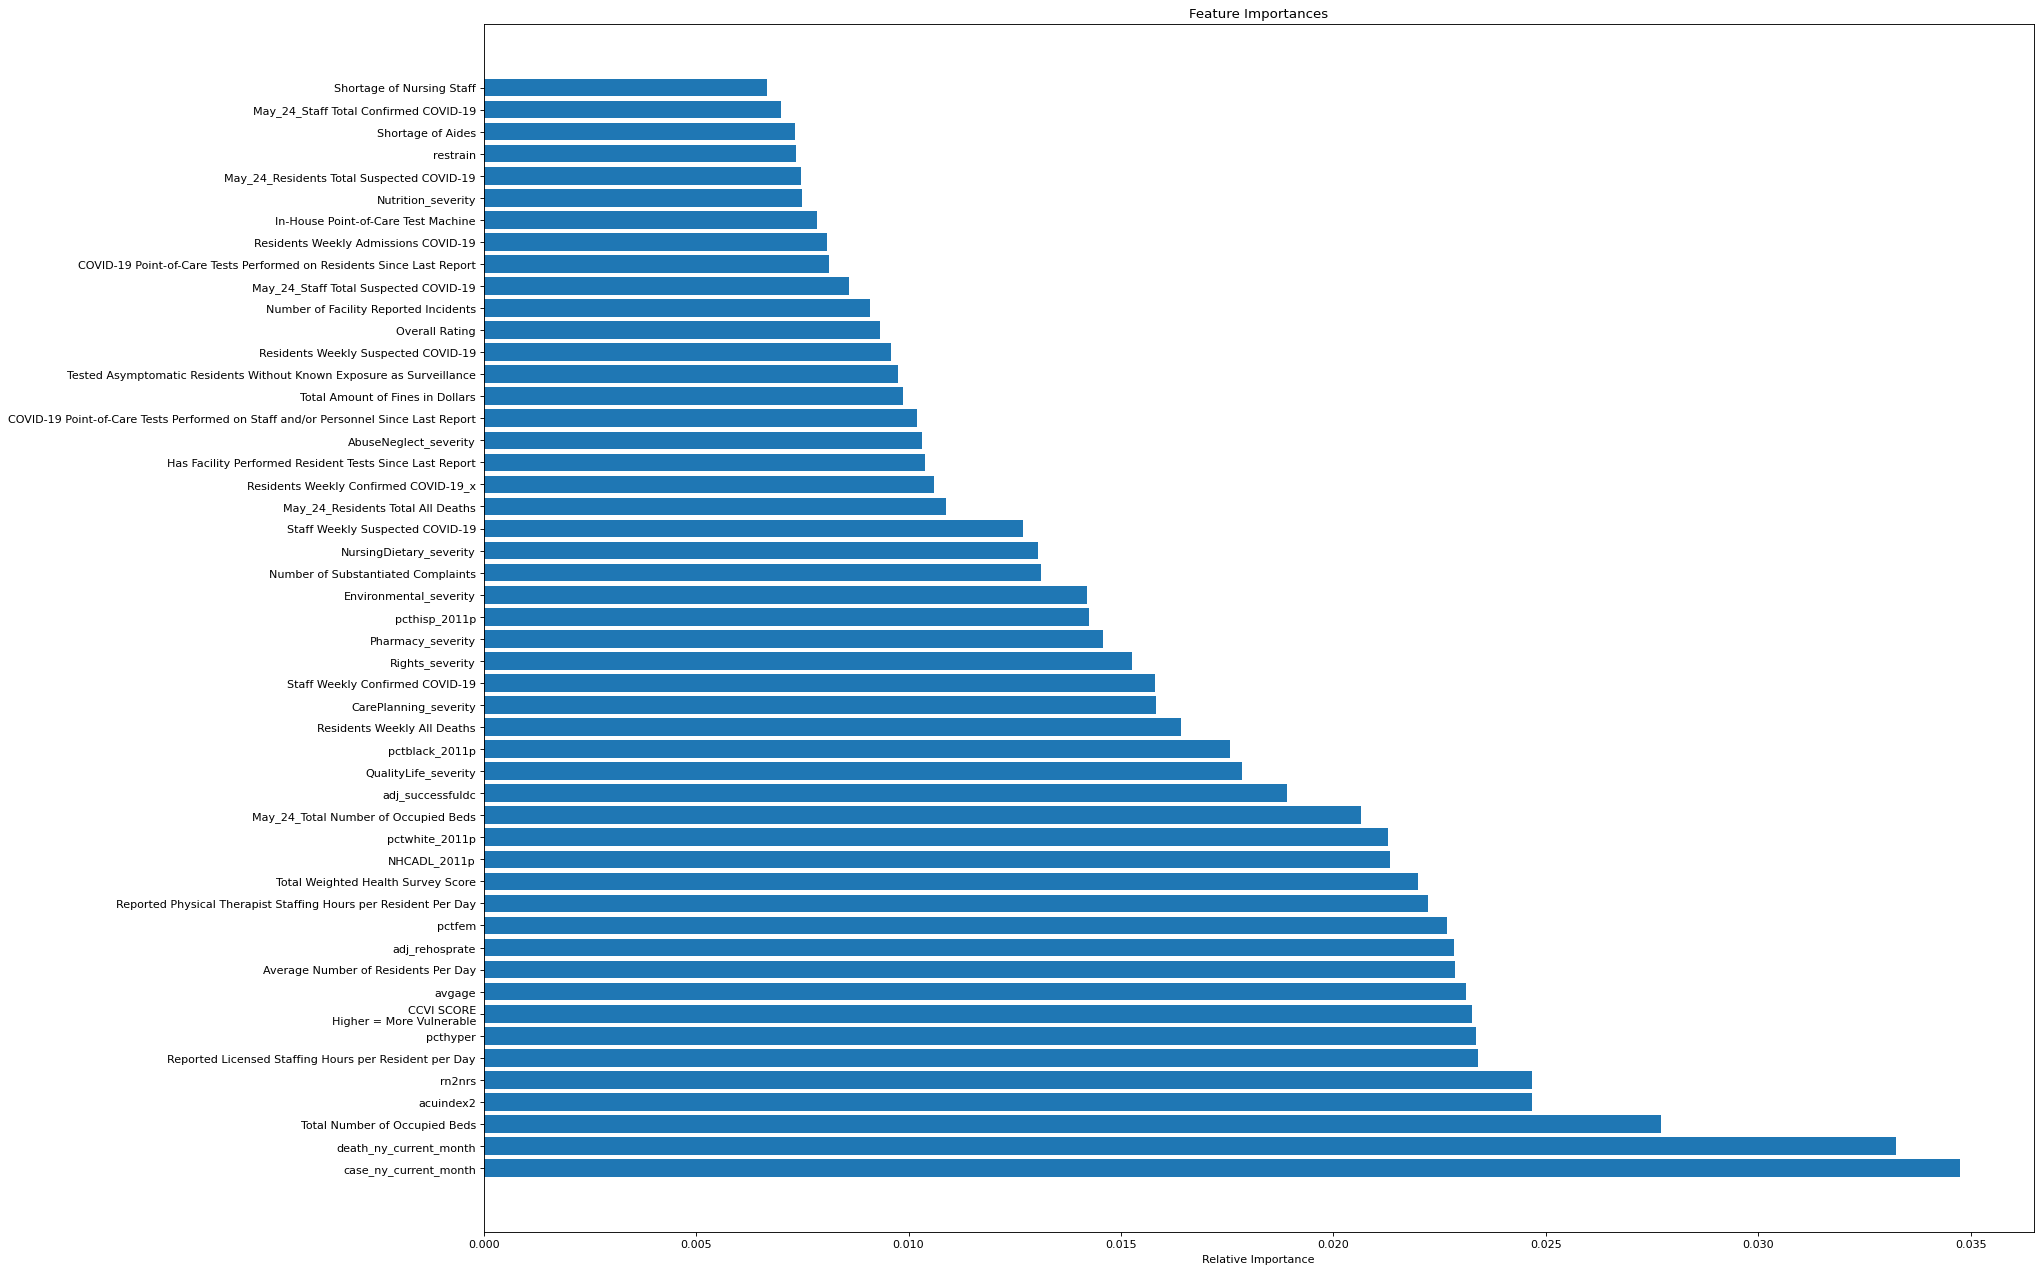

In [ ]:
#display feature importance using random forest
sorted_idx_rf_original = model_rf.best_estimator_.feature_importances_.argsort()[::-1]
rf_columns = visual_feature_import(sorted_idx_rf_original,model_rf.best_estimator_.feature_importances_)

Reason for Not Testing Residents  - Lack of Access to Laboratory 7.96e-05
Number of Ventilators in Use for COVID-19 8e-06
Reason for Not Testing Staff and/or Personnel - Lack of Access to Laboratory 0.0
Staff Weekly COVID-19 Deaths 0.0
Laboratory Type Is Other 0.0
Most Recent Health Inspection More Than 2 Years Ago 0.0
adj_medianlos 0.0
cut_time_month_11 0.0
Resident Access to Testing in Facility 0.0
Laboratory Type Is State Health Dept 0.0
Laboratory Type Is Private Lab 0.0
Reason for Not Testing Residents - Lack of PPE for Personnel  0.0
suspected_but_no_test_staff 0.0
cut_time_month_8 0.0
Reason for Not Testing Residents  - Uncertainty About Reimbursement 0.0
Reason for Not Testing Residents  - Other 0.0
Reason for Not Testing Staff and/or Personnel - Lack of PPE for Personnel  0.0
Reason for Not Testing Staff and/or Personnel - Uncertainty About Reimbursement 0.0
Reason for Not Testing Staff and/or Personnel - Other 0.0
cut_time_month_9 0.0
cut_time_month_10 0.0
Ownership Type_Gove

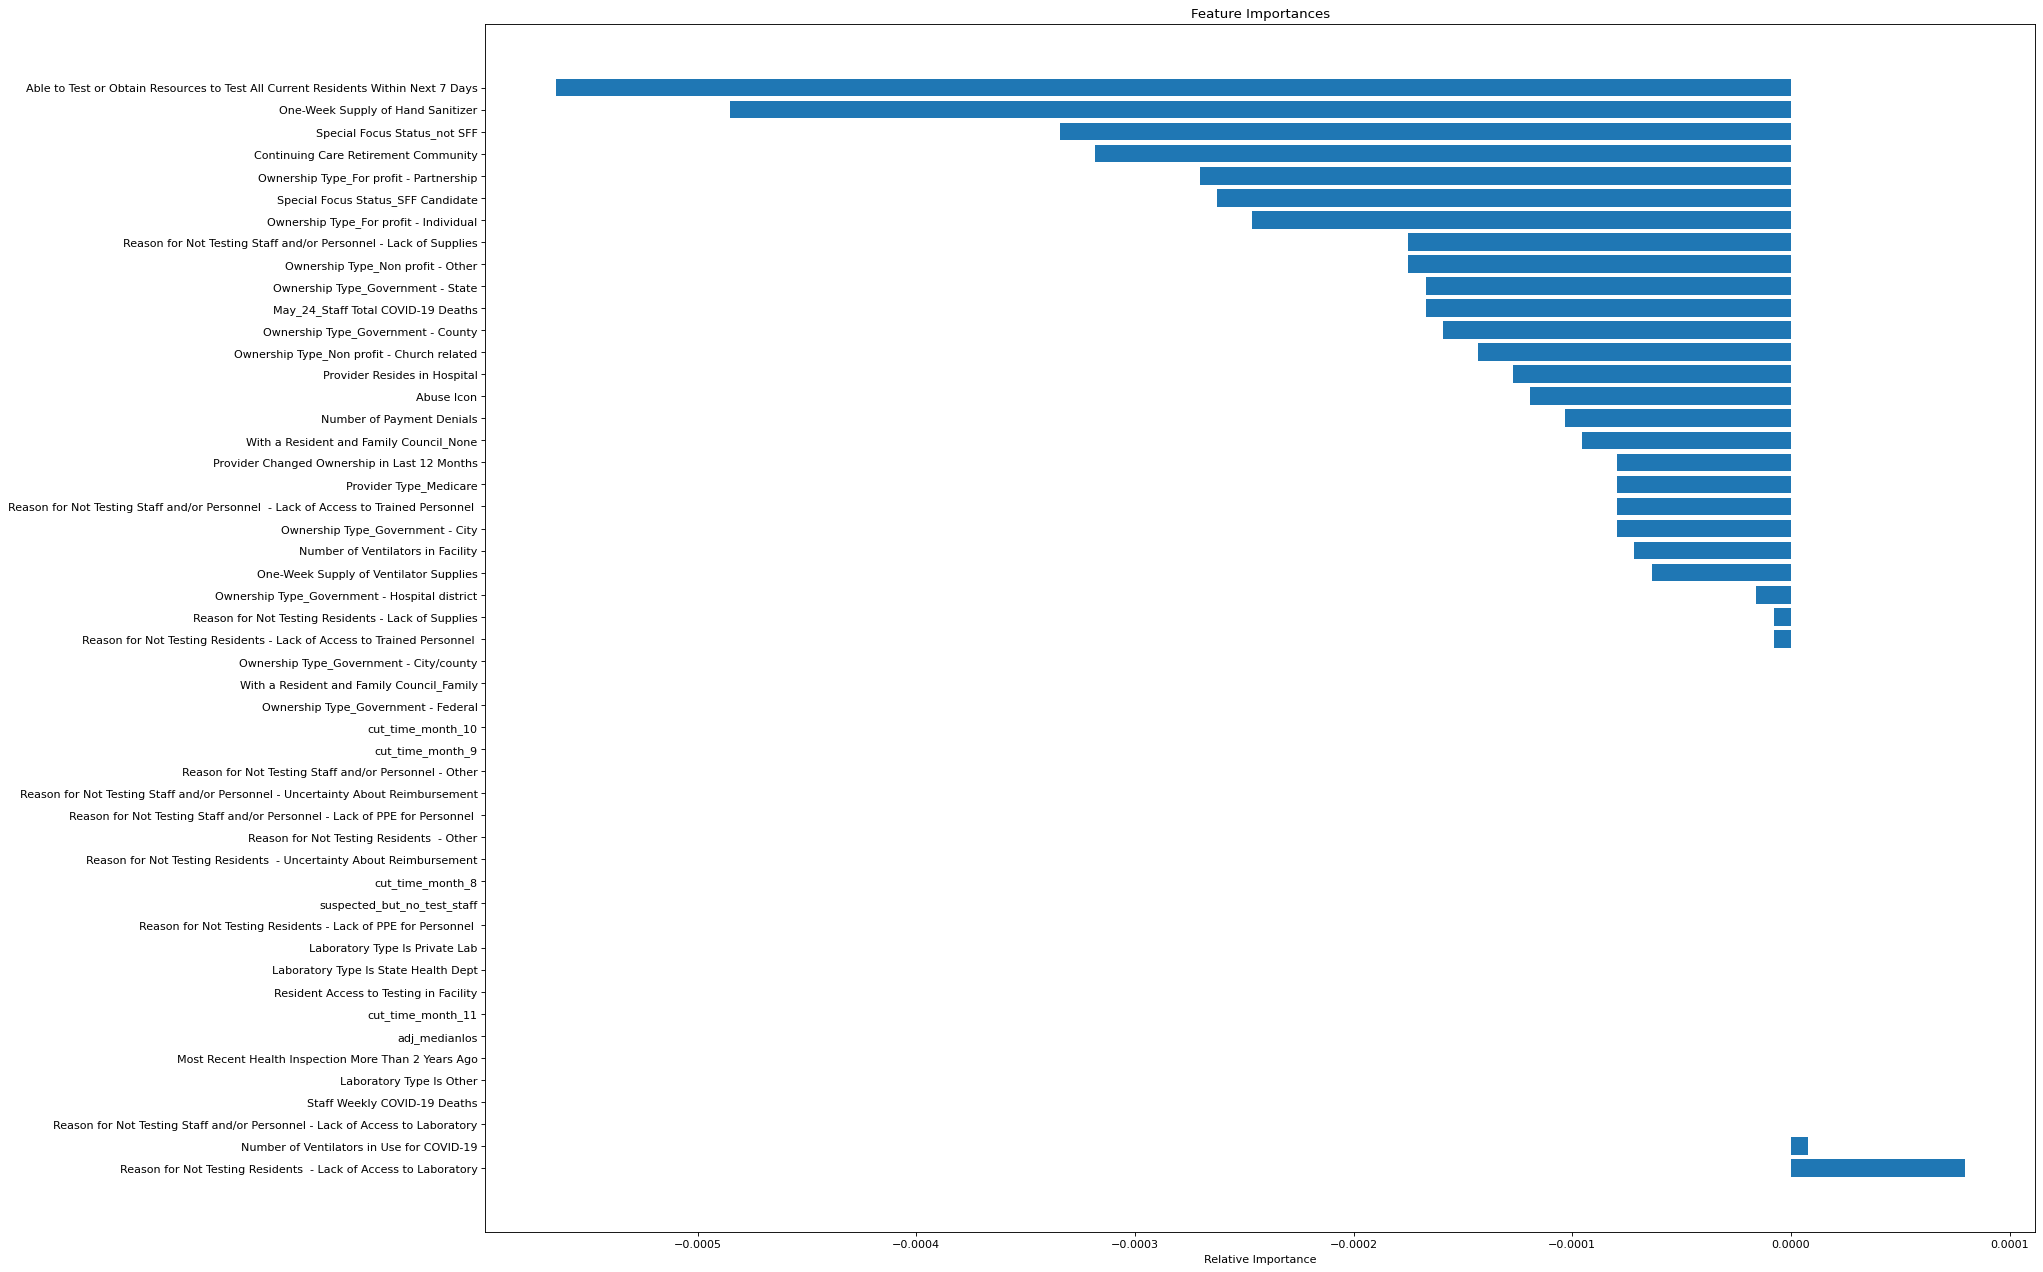

In [ ]:
#perm feature importance using random forest
perm_importance = permutation_importance(model_rf.best_estimator_, test_X, test_y,n_repeats=10,
                                random_state=42, n_jobs=2)

perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
perm_rf_columns = visual_feature_import(perm_sorted_idx,perm_importance.importances_mean)


In [ ]:
#define function to combine two criteria of feature importance
def rank_feature_importance(rf_columns,perm_rf_columns,model_name):
    rf_combine = rf_columns.merge(perm_rf_columns,on = 'feature',how = 'inner',suffixes = (('_'+model_name),('_perm_'+model_name)))
                                  
    rf_combine[(model_name+'_rank')] = rf_combine[('importance_value'+'_'+model_name)].rank(ascending = False)
    rf_combine[('perm_'+model_name+'_rank')] = rf_combine[('importance_value'+'_perm_'+model_name)].rank(ascending = False)
    return rf_combine.sort_values(by  = 'perm_'+model_name+'_rank')
    

In [ ]:
#get the combined feature importance of random forest
rf_combine = rank_feature_importance(rf_columns,perm_rf_columns,'rf')
#rf_combine.to_csv('rf_feature_importance.csv')

## XGBoost（did not apply since the execution time was too long)

In [ ]:


# import xgboost as xgb
# # Initialize XGB and GridSearch
# model_xgb = xgb.XGBClassifier(class_weight = class_weight_dict) 

# # A parameter grid for XGBoost
# param_grid = {
#     'n_estimators': [200],
#     'colsample_bytree': [0.6,0.7,0.8],
#     'max_depth': [3,5],
#     'reg_alpha': [1.0,1.1],
#     'reg_lambda': [1.1],
#     'subsample': [0.7]
# }

# model_xgb= algorithm_pipeline(train_X, train_y,test_X,test_y, model_xgb, 
#                                  param_grid, cv=customized_cv)




In [ ]:
# sorted_idx_xgb_original = model_xgb.best_estimator_.feature_importances_.argsort()[::-1]
# xgb_columns = visual_feature_import(sorted_idx_xgb_original,model_xgb.best_estimator_.feature_importances_)

In [ ]:
# perm_importance = permutation_importance(model_xgb.best_estimator_, test_X, test_y_new)

# perm_sorted_idx = perm_importance.importances_mean.argsort()[::-1]
# perm_xgb_columns = visual_feature_import(perm_sorted_idx,perm_importance.importances_mean)


In [ ]:
# xgb_combine = rank_feature_importance(xgb_columns,perm_xgb_columns,'xgb')
# xgb_combine

## Light GBM

In [ ]:
#construct the cv for cross validation
q = [(np.array(i[0]),np.array(i[1]) )for i in customized_cv]

In [ ]:
#build lgb model to get feature importance
train_data=lgb.Dataset(train_X.values, label = train_y.values,
                    weight=[class_weight_dict[i] for i in train_y])

params = {'boosting_type': 'gbdt',
        'max_depth' : 10,
        'objective': 'multiclass',
          'metric'  :"multi_logloss",
          'num_class':3,
        'nthread': 5,
        'learning_rate': 0.05,
        'max_bin': 512,
        'subsample_for_bin': 200,
        'subsample': 0.7,
        'subsample_freq': 1,
        'colsample_bytree': 0.8,
        'reg_alpha': 1.1,
        'reg_lambda': 2,
        'min_child_samples': 10,
        }
        
lgbm = lgb.train(params,
              train_data,
              200,
              )
y_pred_prob_train = lgbm.predict(train_X)
y_pred_train = np.argmax(y_pred_prob_train,axis = 1)
print('training metrics\n')
print(confusion_matrix(train_y,y_pred_train))  
print(classification_report(train_y,y_pred_train))  
print(accuracy_score(train_y, y_pred_train))
print('For max_depth {0}, The Train AUC score is {1}'.format(depth,roc_auc_score(label_binarize(train_y, classes=labels_class),y_pred_prob_train,multi_class="ovr",average = 'weighted') ))    


y_pred_prob_test = lgbm.predict(test_X)
y_pred_test = np.argmax(y_pred_prob_test,axis = 1)


print('test metrics\n')
print(confusion_matrix(test_y,y_pred_test))  
print(classification_report(test_y,y_pred_test))  
print(accuracy_score(test_y, y_pred_test))


test_auc = roc_auc_score(label_binarize(test_y, classes=labels_class),y_pred_prob_test,multi_class="ovr",average = 'weighted') 
print('For best max_depth {0}, The Test AUC score is {1}'.format(depth, test_auc))
                                                                



training metrics

[[113021  66183  34909]
 [   730   6030    961]
 [   338    790   3298]]
              precision    recall  f1-score   support

         0.0       0.99      0.53      0.69    214113
         1.0       0.08      0.78      0.15      7721
         2.0       0.08      0.75      0.15      4426

    accuracy                           0.54    226260
   macro avg       0.39      0.68      0.33    226260
weighted avg       0.94      0.54      0.66    226260

0.540745160434898
For max_depth 20, The Train AUC score is 0.2969188303386044
test metrics

[[6099 2441 3108]
 [  90  192  233]
 [  79  145  183]]
              precision    recall  f1-score   support

         0.0       0.97      0.52      0.68     11648
         1.0       0.07      0.37      0.12       515
         2.0       0.05      0.45      0.09       407

    accuracy                           0.52     12570
   macro avg       0.36      0.45      0.30     12570
weighted avg       0.91      0.52      0.64     12570



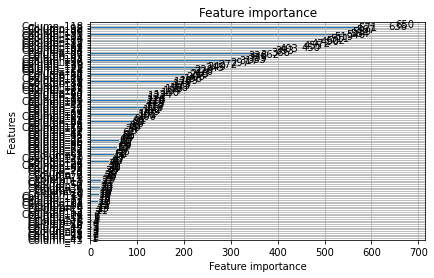

In [ ]:
lgb.plot_importance(lgbm)

CCVI SCORE
Higher = More Vulnerable 650
rn2nrs 636
pcthyper 571
adj_rehosprate 567
acuindex2 559
case_ny_current_month 554
death_ny_current_month 546
pctfem 519
Reported Licensed Staffing Hours per Resident per Day 511
avgage 502
Reported Physical Therapist Staffing Hours per Resident Per Day 490
Total Weighted Health Survey Score 472
NHCADL_2011p 455
adj_successfuldc 450
Average Number of Residents Per Day 403
May_24_Total Number of Occupied Beds 393
Total Number of Occupied Beds 386
pctwhite_2011p 362
pctblack_2011p 336
QualityLife_severity 335
pcthisp_2011p 333
CarePlanning_severity 317
Rights_severity 297
Pharmacy_severity 272
Environmental_severity 249
NursingDietary_severity 245
Number of Substantiated Complaints 220
Staff Weekly Confirmed COVID-19 220
May_24_Residents Total All Deaths 213
Staff Weekly Suspected COVID-19 210
Total Amount of Fines in Dollars 203
COVID-19 Point-of-Care Tests Performed on Staff and/or Personnel Since Last Report 198
Residents Weekly All Deaths 189
M

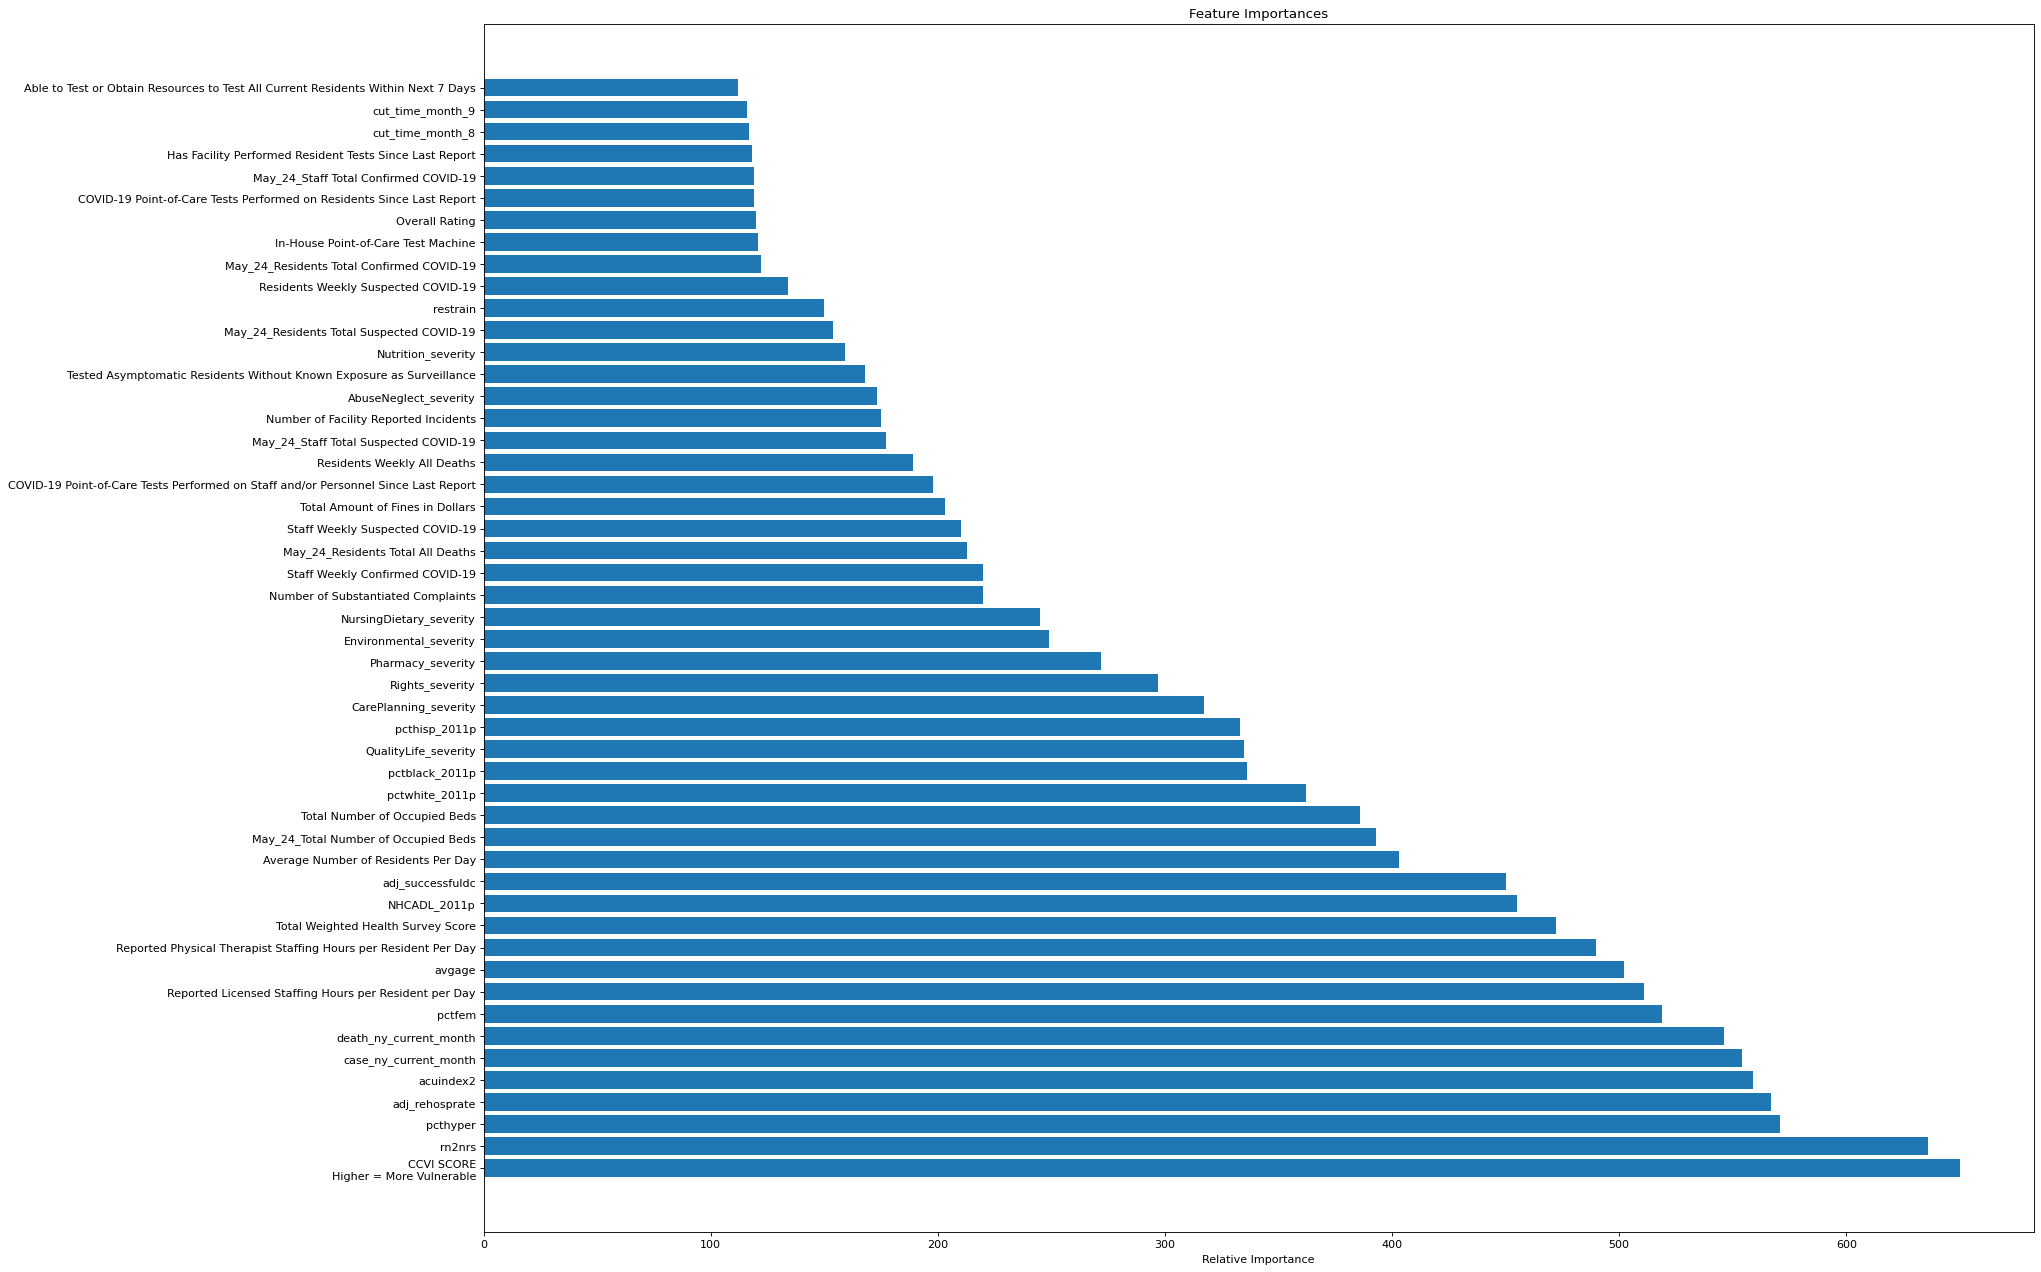

In [ ]:
#display lgb feature importance
sorted_idx_LGBM_original = lgbm.feature_importance().argsort()[::-1]
LGBM_columns = visual_feature_import(sorted_idx_LGBM_original,lgbm.feature_importance())

In [ ]:
#combine random forest and lgb feature importance to access the final aggregated feature importance index
LGBM_columns['importance_rank_lgbm'] = LGBM_columns[('importance_value')].rank(ascending = False)
combine = rf_combine.merge(LGBM_columns,on = 'feature',how = 'inner')
#combine = combine.merge(lgbm_combine,on = 'feature',how = 'inner')
combine['total'] = (combine['rf_rank']+combine['importance_rank_lgbm'])
combine.sort_values('total',inplace= True)
combine.to_csv('/content/drive/My Drive/CapstoneProject/Data/Processed Output/combine_feature_impor_classfication.csv')
combine
selected_features = combine.iloc[:50,0]
selected_features.to_csv('/content/drive/My Drive/CapstoneProject/Data/Processed Output/selected_feature.csv')

In [ ]:
selected_features = pd.read_csv('/content/drive/My Drive/CapstoneProject/Data/Processed Output/selected_feature.csv')

In [ ]:
selected_features

,Unnamed: 0,feature
0,127,case_ny_current_month
1,124,rn2nrs
2,131,death_ny_current_month
3,129,acuindex2
4,117,CCVI SCORE\nHigher = More Vulnerable
5,118,pcthyper
6,130,adj_rehosprate
7,120,Reported Licensed Staffing Hours per Resident ...
8,115,avgage
9,122,Total Number of Occupied Beds


## Final selected features

In [ ]:
selected_features

,CCVI SCORE Higher = More Vulnerable
0,rn2nrs
1,Tested Asymptomatic Staff and/or Personnel in ...
2,Provider Type_Medicare
3,Residents Weekly Confirmed COVID-19_x
4,Average Number of Residents Per Day
5,Residents Weekly COVID-19 Deaths_x
6,death_ny_current_month
7,May_24_Total Number of Occupied Beds
8,Staff Weekly Confirmed COVID-19
9,Three or More Confirmed COVID-19 Cases This Week


In [ ]:
for i in selected_features:
    print(i)

# Combine Structure data & Unstructure data 




In [ ]:
train_X

In [ ]:
#combine structured and unstructured data
train_X = pd.concat([data_X_id_train,train_X[selected_features]],axis = 1)
test_X = pd.concat([data_X_id_test,test_X[selected_features]],axis = 1)

train_X = train_X.merge(text_X,how = 'left',right_on='facility_id', left_on='Federal Provider Number')
test_X = test_X.merge(text_X,how = 'left',right_on='facility_id', left_on='Federal Provider Number')
test_X = test_X.drop(['Federal Provider Number','facility_id'],axis = 1)
train_X = train_X.drop(['Federal Provider Number','facility_id'],axis = 1)

In [ ]:
test_X = test_X.fillna(0)
train_X = train_X.fillna(0)

#Hybrid Model Classification

## SMOTE

previous method to deal with unbalanced data(now using the label weights to solve this problem)

In [ ]:

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 33)

In [ ]:
# train_X_new, train_y_new = sm.fit_sample(train_X, train_y.ravel())

# # observe that data has been balanced
# pd.Series(train_y_new).value_counts().plot.bar()

## Algorithms

In [ ]:
plt.rcParams.update({'figure.figsize': (12.0, 12.0)})


XGBoost(not used since running time was too long)

In [ ]:
# # Initialize XGB and GridSearch
# model_xgb = xgb.XGBClassifier(nthread=-1,class_weight = class_weight_dict) 

# # A parameter grid for XGBoost
# param_grid_xgb = {
#     'n_estimators': [200],
#     'colsample_bytree': [0.7],
#     'max_depth': [3,7,15],
#     'reg_alpha': [1.1],
#     'reg_lambda': [1.1],
#     'subsample': [0.7,0.8]
# }

# xgb_model = algorithm_pipeline(train_X, train_y, test_X,test_y, model_xgb, 
#                                  param_grid_xgb, cv = customized_cv)





### Random Forest

In [ ]:
#random forest model applied to combiend data
rf = RandomForestClassifier(class_weight = class_weight_dict)


param_grid_rf = {'n_estimators' :[100,200,400],  
                 'criterion':["gini", "entropy"],
                 'max_features':["auto","log2"],
                 'max_depth':[5,7,10],
                 'mini_sample_split':[]
                
                 
                 }



                 
model_rf = algorithm_pipeline(train_X, train_y, test_X,test_y,rf, 
                                 param_grid_rf, cv=customized_cv)





Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.5min finished


{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
training metrics

[[121931  67311  24871]
 [     0   7648   1006]
 [     0    509   2984]]
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73    214113
         1.0       0.10      0.88      0.18      8654
         2.0       0.10      0.85      0.18      3493

    accuracy                           0.59    226260
   macro avg       0.40      0.77      0.36    226260
weighted avg       0.95      0.59      0.70    226260

0.5858879165561743
test metrics

[[6779 3357 1512]
 [   4  394  190]
 [   2  234   98]]
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74     11648
         1.0       0.10      0.67      0.17       588
         2.0       0.05      0.29      0.09       334

    accuracy                           0.58     12570
   macro avg       0.38      0.52      0.33     12570
weighted avg       0.93    

### Light GBM

In [ ]:
def algorithm_pipeline(X_train_data, y_train_data, test_X_data,test_y_data,
                       model, param_grid, cv=customized_cv, scoring_fit='f1_macro',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    # Root Mean Squared Error
    print(fitted_model.best_params_)
    
    test_predict = fitted_model.best_estimator_.predict(test_X_data)
    train_predict = fitted_model.best_estimator_.predict(X_train_data)
    print('training metrics\n')
    print(confusion_matrix(y_train_data,train_predict))  
    print(classification_report(y_train_data,train_predict))  
    print(accuracy_score(y_train_data, train_predict))
    print(roc_auc_score(label_binarize(train_y, classes=labels_class), label_binarize(train_predict, classes=labels_class),multi_class="ovr",average = 'weighted'))
    print('test metrics\n')
    print(confusion_matrix(test_y_data,test_predict))  
    print(classification_report(test_y_data,test_predict))  
    print(accuracy_score(test_y_data, test_predict))
    print(roc_auc_score(label_binarize(test_y, classes=labels_class), label_binarize(test_predict, classes=labels_class),multi_class="ovr",average = 'weighted'))


    return fitted_model

In [ ]:
#lgb model applied to combiend data
for max_depth in [3,5,7,10,13]:
    # print('learning_rate{}'.format(learning_rate))
    print('depth{}'.format(max_depth))


    train_data=lgb.Dataset(train_X.values, label = train_y.values,
                        weight=[class_weight_dict[i] for i in train_y])

    params = {'boosting_type': 'gbdt',
            'max_depth' : max_depth,
            'objective': 'multiclass',
              'metric'  :"multi_logloss",
              'num_class':3,
            'nthread': 5,
            'learning_rate': 0.03,
            'max_bin': 512,
            'subsample_for_bin': 200,
            'subsample': 0.7,
            'subsample_freq': 1,
            'colsample_bytree': 0.8,
            'reg_alpha': 1.1,
            'reg_lambda': 2,
            'min_child_samples': 10,
            'num_leaves':20

            }
            
    lgbm = lgb.train(params,
                  train_data,
                  200,
                  )
    # print('leaves{}'.format(n))
    y_pred_prob_train = lgbm.predict(train_X)
    y_pred_train = np.argmax(y_pred_prob_train,axis = 1)
    print('training metrics\n')
    print(confusion_matrix(train_y,y_pred_train))  
    print(classification_report(train_y,y_pred_train))  
    print(accuracy_score(train_y, y_pred_train))
    print('For max_depth {0}, The Train AUC score is {1}'.format(10,roc_auc_score(label_binarize(train_y, classes=labels_class),label_binarize(y_pred_train, classes=labels_class),multi_class="ovr",average = 'weighted') ))    


    y_pred_prob_test = lgbm.predict(test_X)
    y_pred_test = np.argmax(y_pred_prob_test,axis = 1)


    print('test metrics\n')
    print(confusion_matrix(test_y,y_pred_test))  
    print(classification_report(test_y,y_pred_test))  
    print(accuracy_score(test_y, y_pred_test))


    test_auc = roc_auc_score(label_binarize(test_y, classes=labels_class),label_binarize(y_pred_test, classes=labels_class),multi_class="ovr",average = 'weighted') 
    print('For best max_depth {0}, The Test AUC score is {1}'.format(10, test_auc))
                                                                    



depth3
training metrics

[[121489  42903  49721]
 [     0   4026   3695]
 [     0   1558   2868]]
              precision    recall  f1-score   support

         0.0       1.00      0.57      0.72    214113
         1.0       0.08      0.52      0.14      7721
         2.0       0.05      0.65      0.09      4426

    accuracy                           0.57    226260
   macro avg       0.38      0.58      0.32    226260
weighted avg       0.95      0.57      0.69    226260

0.5674135949792274
For max_depth 10, The Train AUC score is 0.7778804053978187
test metrics

[[6749 2252 2647]
 [   0  252  263]
 [   0  191  216]]
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73     11648
         1.0       0.09      0.49      0.16       515
         2.0       0.07      0.53      0.12       407

    accuracy                           0.57     12570
   macro avg       0.39      0.53      0.34     12570
weighted avg       0.93      0.57      0.69    

---------------------------------------------------------------------